In [2]:
cd /home/ec2-user/SageMaker/brandClassification

/home/ec2-user/SageMaker/brandClassification


In [3]:
import boto3
import sagemaker

print(sagemaker.__version__)

sess = sagemaker.Session()
bucket = sess.default_bucket()

2.119.0


In [4]:
train_dir = 'train_RecordIo_lst_file'
test_dir = 'test_Io_test_lst_file'
# val_dir = 'val'
train_dir

'train_RecordIo_lst_file'

In [5]:
prefix = 'Brand-classification'
training_input_path   = sess.upload_data(train_dir, key_prefix=prefix+'/training')
validation_input_path = sess.upload_data(test_dir, key_prefix=prefix+'/validation')
s3_output = 's3://{}/{}/output/'.format(bucket, prefix)

## Get the name of the image classification algorithm in our region

In [6]:

from sagemaker import image_uris

region = boto3.Session().region_name    
container = image_uris.retrieve('image-classification', region)
print(container)


811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1


## Configure the training job

In [7]:
role = sagemaker.get_execution_role()

ic = sagemaker.estimator.Estimator(container,
                                   role, 
                                   instance_count=1, 
                                   instance_type='ml.p3.2xlarge',
                                   output_path=s3_output)


## Set algorithm parameters

In [19]:
ic.set_hyperparameters(num_layers=18,               # Train a Resnet-18 model
                       use_pretrained_model=0,      # Train from scratch
                       num_classes=5,               # PET, HDEP and OTHERS                        
                       mini_batch_size=64,
                       num_training_samples=1500,  # Number of training samples
                       image_shape = '3,220,220',
                       epochs=10)                   # Learn the training samples 10 times
# 

## Set dataset parameters

In [20]:
train_data = sagemaker.TrainingInput(training_input_path, 
                                        distribution='FullyReplicated', 
                                        content_type='application/x-recordio',
                                        s3_data_type='S3Prefix')

validation_data = sagemaker.TrainingInput(validation_input_path,
                                             distribution='FullyReplicated', 
                                             content_type='application/x-recordio', 
                                             s3_data_type='S3Prefix')

s3_channels = {'train': train_data, 'validation': validation_data}

## Train the model

In [21]:
ic.fit(inputs=s3_channels)

2022-12-16 12:32:06 Starting - Starting the training job...
2022-12-16 12:32:32 Starting - Preparing the instances for trainingProfilerReport-1671193926: InProgress
...............
2022-12-16 12:34:50 Downloading - Downloading input data...
2022-12-16 12:35:31 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Fri Dec 16 12:35:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                   

## Deploy the model

In [24]:
import time
tf_endpoint_name = 'Brand-classification-model-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

tf_predictor = ic.deploy(initial_instance_count=1,
                         instance_type='ml.t2.medium',         # $0.05 per hours  
                         endpoint_name=tf_endpoint_name) 

-----------------!

## Download a test image

--2022-12-16 12:57:10--  https://lactantia.ca/wp-content/uploads/2018/07/0001_00068200466484_A1C1.png
Resolving lactantia.ca (lactantia.ca)... 18.154.227.31, 18.154.227.56, 18.154.227.32, ...
Connecting to lactantia.ca (lactantia.ca)|18.154.227.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 386815 (378K) [image/png]
Saving to: ‘/tmp/test.jpg’

100%[======================================>] 386,815     --.-K/s   in 0.05s   

2022-12-16 12:57:11 (7.64 MB/s) - ‘/tmp/test.jpg’ saved [386815/386815]



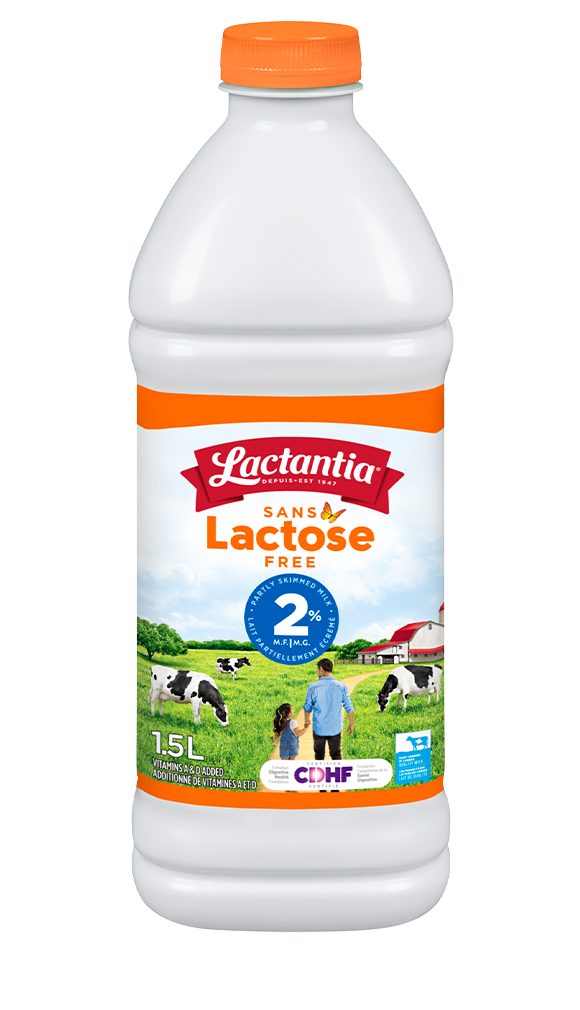

In [30]:
# Dog
!wget -O /tmp/test.jpg https://lactantia.ca/wp-content/uploads/2018/07/0001_00068200466484_A1C1.png
file_name = '/tmp/test.jpg'
from IPython.display import Image
Image(file_name)

## Predict test image

In [31]:
import boto3, json
import numpy as np

runtime = boto3.Session().client(service_name='runtime.sagemaker')

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

response = runtime.invoke_endpoint(EndpointName=tf_predictor.endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)

result = response['Body'].read()
result = json.loads(result)
index = np.argmax(result)
print(result[index], index)

# 1-PET 0       2-HDPE 1         others 2

if index == 0:
    print('cocacola')
elif index == 1:
    print('lactania')
elif index == 2:
    print('ordinary')
elif index == 3:
    print('pepsi')
elif index == 4:
    print('starbucks')
else:
    print('image does not access ')

0.9984434247016907 1
lactania


## Delete endpoint

In [ ]:
ic_predictor.delete_endpoint()